### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

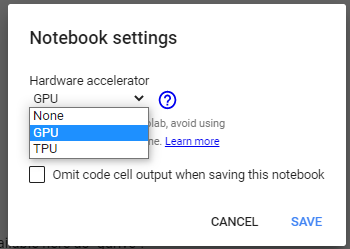

In [ ]:
#@title Setup Colab_ssh and prepare other things
# Install colab_ssh
!pip install colab_ssh --upgrade
!mkdir /content/mount
# from colab_ssh import launch_ssh
# launch_ssh('1xEyLqOzSCuiHkxbKc3pcCEtJOg_2a4omqcYK7agN8gnxP5K', 'cookies123')

In [ ]:
!apt -y install sshfs vi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package vi


In [ ]:
#@title Launch cloudflared password is test123
#We still need this to have terminal access to the machine
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared('test123')


In [ ]:
#option mount client side
#we need to do a ssh login first because the machine needs to pass the zero trust policy. 
#Link will be provided to login
#sshfs won't output this option
#!ssh -o ProxyCommand="/content/cloudflared access ssh --hostname %h" Colaborators@endovelicus.mamede.xyz


In [ ]:
#@title Check if GPU mode is activated.
!nvidia-smi

Sat Oct 30 04:21:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#We need to add the password in this string so that we can call it from here. So far this version works inside the console
 #!sshfs -o  reconnect,ServerAliveInterval=15,ServerAliveCountMax=3,ProxyCommand="/content/cloudflared access ssh --hostname %h" Colaborators@endovelicus.mamede.xyz:/D:/ /content/mount

#ssh blablabla.trycloudflare.com  -R 10000:localhost:22
#  !sshfs -p 10000  'Mamede lab'@127.0.0.1:/D:/ /content/mount/

 #!sshfs -o ProxyCommand="/content/cloudflared access ssh --hostname %h" Colaborators@endovelicus.mamede.xyz:/D:/ /content/mount

In [ ]:
#@title Mount Google Drive to /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Install all the needed modules with pip
!pip install dask>2.30.0
!pip install nd2reader
!pip install pims
!pip install flowdec
!pip install aicsimageio==3.2.3

     |████████████████████████████████| 85 kB 2.7 MB/s 
  Created wheel for pims: filename=PIMS-0.5-py3-none-any.whl size=84326 sha256=858218e94dc8d3c006eea4533a1d5328ec12456f9f00425260844c8e449517ac
  Stored in directory: /root/.cache/pip/wheels/75/02/a9/86571c38081ba4c1832eb95430b5d588dfa15a738e2a603737
Successfully built pims
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 61 kB 3.0 MB/s 
     |████████████████████████████████| 791 kB 8.0 MB/s 
     |████████████████████████████████| 6.3 MB 41.7 MB/s 
     |████████████████████████████████| 628 kB 46.5 MB/s 
     |████████████████████████████████| 29.6 MB 62 kB/s 
     |████████████████████████████████| 1.0 MB 43.3 MB/s 
     |████████████████████████████████| 125 kB 51.8 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: dask
    Found

In [ ]:
#@title Load Modules and custom libraries
%matplotlib inline
import pims
from pims import ND2_Reader
import os
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from flowdec import data as fd_data
# import pims
# import pims
from flowdec import restoration as fd_restoration
from flowdec import data as fd_data
from flowdec import psf as fd_psf
import dask
import dask.array as da
import tifffile as tf
from nd2reader import ND2Reader
# from pims import ND2_Reader 
# import aicsimageio.vendor.omexml as ome
import glob
import time, sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Notebooks/libraries')

from deco_libraries import update_progress, pimsmeta2OMEXML, Nd2meta2OMEXML, observer, init_RL_algo, deconv, depth_divide


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2048000/45929032 bytes (4.5%)5160960/45929032 bytes (11.2%)8372224/45929032 bytes (18.2%)11722752/45929032 bytes (25.5%)14958592/45929032 bytes (32.6%)18251776/45929032 bytes (39.7%)21512192/45929032 bytes (46.8%)24551424/45929032 bytes (53.5%)27738112/45929032 bytes (60.4%)30842880/45929032 bytes (67.2%)34136064/45929032 bytes (74.3%)37429248/45929032 bytes (81.5%)

In [ ]:
#THINGS TO CHANGE!!!!! Always keep /*.nd2 at the end
#For gui make a function with all this input for verification purposes when loading the files
# dirname = "D:/igfp1_caruby5_continue001trigger002.nd2"
# dirname = "D:/JM/20201222caru3/Carubyigfp_F2_Nh4cl_vitc_rutin_BVD002.nd2"
# dirname = "X:/Mamede/JM/2020/20200626/igfp1_caruby5_continue001trigger00*.nd2"
#like this format.D:\Stephanie\20210702F2
# dirname = "D:/JM/20210716_8ibidi_every3/*.nd2"
dirname = "/content/mount/Stephanie/20211026Ghost/*.nd2" #@param {type:"string"}
# dirname = "D:/Stephanie/20210820sfGFP/*.nd2"
# dirname = "D:/JM/20210806-L670/igfpoptir3in_hela670_nh4cl_pbn_vitc_pump002*.nd2"
filelist = glob.glob(dirname)
filelist.sort()

# filelist = filelist[2:3]

print(filelist)
# print(filelist[1])

['/content/mount/Stephanie/20211026Ghost/Caru3_iGFP_1_5_PLB_VitC_Nuc_Nh4Cl_Vera_1loop.nd2']


In [ ]:
#@title Remove the file indexes
#rm 
# filelist.pop()

In [ ]:
#Load the first file for reference and what's inside the file
frames = ND2Reader(filelist[0])
print(frames.sizes)
#Grab metadata
metadata = frames.metadata
print(metadata['channels'])

#If you don't have enough VRAM divide the XY to do the deconvolution that is automatically assembled after
xdivide = round(frames.sizes['x']/1024)
ydivide = round(frames.sizes['y']/1024)
depthdivide = depth_divide(xdivide, ydivide)
frames

{'x': 1024, 'y': 1024, 'c': 3, 't': 137, 'z': 15, 'v': 45}
['mirfp670', 'FITc', 'mRuby3']


<FramesSequenceND>
Axes: 6
Axis 'x' size: 1024
Axis 'y' size: 1024
Axis 'c' size: 3
Axis 't' size: 137
Axis 'z' size: 15
Axis 'v' size: 45
Pixel Datatype: <class 'numpy.float64'>

In [ ]:
# reader = frames 
frames.iter_axes = 'tc'  # 't' is the default already
frames.bundle_axes = 'zyx'  # when 'z' is available, this will be default
# metadata['pixel_microns']
# frames[2]
frames[0][0]

0.21420169761064

In [ ]:
xml = Nd2meta2OMEXML(frames,time_offset=0,maxT=None,verbose=False)
xml.image().Pixels.PhysicalSizeZ


0.5

In [ ]:
#@title Create PSFs based on the metadatas
#Need to make this a big more automatic, but indexing all the files and iterations is not easy
#In the version where the PSF is estimated by flowdec is easier because everything was set to automatic


# na = meta['NA']
    
    
    
na = 1.4
#ra = meta['refractive_index1']
ra = 1.5156
z = int(frames.sizes['z'])
# z= 31
# z = 6
#     x = frames.sizes['x'] // 2
#     y = frames.sizes['y'] // 2
#     z = 26
x = 65
y = 65
res_z = xml.image().Pixels.PhysicalSizeZ
# res_z = xml.image().Pixels.PhysicalSizeZ
res_xy =  metadata['pixel_microns']
distance_cover = 0
##Make better with automatic wavelength from metadata and a loop and a dictionary with the PSFs
psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.670 , size_z=  z, size_x=  x , size_y=  y
    ,m = 60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = 130
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psf647 = psf.generate()    

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.620 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = 130
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psfruby = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.535 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = 130
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psfgfp = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.420 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = 130
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psfdapi = psf.generate()  

#Clip Top and bottom, I found that if the PSF is calculated with distance from coverslip, it is flipped from Fiji
#As in, it is Top to Bottom, I acquire the images Bottom to Top
# remove = 13
# remove = 14
# psf647 = np.flip(psf647,
# #                  axis=0
#                 )[remove:-remove]

# psfgfp = np.flip(psfgfp,
# #                  axis=0
#                 )[remove:-remove]
# psfdapi = np.flip(psfdapi,
# #                   axis=0
#                  )[remove:-remove]
# psfruby = np.flip(psfruby,
# #                   axis=0
#                  )[remove:-remove]

print(psf647.shape)
print(psfruby.shape)
# "C:/Users/Mamede/PSF/"
import pims
pims.Frame(psf647)

(15, 65, 65)
(15, 65, 65)


In [ ]:

# from flowdec import restoration as fd_restoration
# algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=psfgfp.ndim
#                                                     # , pad_mode=pad_mode
#                                                     # ,pad_min=pad_min
#     #                                                     ,observer_fn=observer
#                                                     #,real_domain_fft=True
#                                                     #,device='/cpu:0'
#                                                    ).initialize()

print(filelist)
# fname2 = filelist[1]
fname1 = filelist[0]

['/content/mount/Stephanie/20211026Ghost/Caru3_iGFP_1_5_PLB_VitC_Nuc_Nh4Cl_Vera_1loop.nd2']


In [ ]:

# frames.parser._raw_metadata.image_metadata
def get_deltaT(filename1,filename2):
    
    import pathlib
#     frames = ND2Reader(filelist[0])
#     a = frames.metadata['date']
#     frames = ND2Reader(filelist[1])
#     b = frames.metadata['date']
    fname1 = pathlib.Path(filename1)
    fname2 = pathlib.Path(filename2)
    import datetime
    mtime2 = datetime.datetime.fromtimestamp(fname2.stat().st_ctime)
    mtime1 = datetime.datetime.fromtimestamp(fname1.stat().st_ctime)
#     print(mtime2,mtime1)
#     print(fname2.stat().st_ctime - fname1.stat().st_ctime)
    return fname2.stat().st_ctime - fname1.stat().st_ctime
    # time_offset = 71146.03463482857
# fname2 = filelist[1]
   
# print(get_deltaT(fname1,fname2)/60)
# print(get_deltaT(fname1,fname2)/60)

# time_offset = get_deltaT(fname1,fname2)

In [ ]:
#@title Check final filelist
fname1 = filelist[0]
# filelist.pop(0)
# filelist.pop(0)
filelist

['/content/mount/Stephanie/20211026Ghost/Caru3_iGFP_1_5_PLB_VitC_Nuc_Nh4Cl_Vera_1loop.nd2']

In [ ]:
!nvidia-smi

Sat Oct 30 04:25:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Default title text
#these are the settings you need to look at

n_iters = 100 #@param
# keep this one always at 100
ram = False #@param {type:"boolean"}
savePRJ = True #@param {type:"boolean"}
 # if you want the projection Z have it at True, if not, False
saveStack = False #@param {type:"boolean"}
# if you want the Z-stack have it at True, if not, False 


# time_offset = 0 #@param
# maxT = 25
#do not worry about these ones
#@markdown If you want to add stop at a interval timepoint change here:
maxT = None #@param

#If it's a broken experiment, you need to do concat Time True, 
#so that it makes the 0 from file #2 to be the diference between the files
#@markdown In case the files need to concatenate the time later in case of 
#@markdown broken experiments
concattime = False #@param {type:"boolean"}

In [ ]:
#@title Crunch it
_first = 21 #@param
_last = frames.sizes['v'] #@param


algo = init_RL_algo(psfgfp.ndim
                  #  ,pad_mode='2357' ,pad_min=(2,24,24)
                   ,pad_mode='log2' 
                    #,pad_min=(4,24,24)
#                       ,pad_mode='none'
                  )

for fname in filelist:
    #to add the real time of experiment when we have to split it into different files
    if concattime:
#         time_offset = get_deltaT(filelist[0],fname)
        time_offset = get_deltaT(fname1,fname)
#         time_offset = 72424
#         time_offset = 72424
    else: time_offset = 0
    frames =  ND2Reader(fname)
    frames.iter_axes = 't'  # 't' is the default already
    frames.bundle_axes = 'zyx'  # when 'z' is available, this will be default

    channels = frames.metadata['channels']
    metadata = frames.metadata
    
    if saveStack:
        xml = Nd2meta2OMEXML(frames,time_offset=time_offset,maxT=maxT,verbose=False)
    if savePRJ:
        prjxml = Nd2meta2OMEXML(frames, project=True,time_offset=time_offset,maxT=maxT,verbose=False)

    chunk_size=(frames.sizes['z'],frames.sizes['y']//ydivide,frames.sizes['x']//xdivide)

    # frames.iter_axes = 'v'
    # for frame in frames:
#     for visit in range(22,25):
#         frames.sizes['v']):
    # for visit in range(11,frames.sizes['v']):
    # for visit in range(0,51):
    for visit in range(_first,_last):

        frames.default_coords['v'] = visit
        stackfile = '/content/drive/MyDrive/Colab Notebooks/'+os.path.basename(fname)[:-4]+"_v"+str(visit+1).zfill(3)+'.ome.tiff'
        # prjfile = '/content/drive/MyDrive/Colab Notebooks/'+os.path.basename(fname)[:-4]+"_v"+str(visit+1).zfill(3)+'_PRJ.ome.tiff'
        prjfile = fname[:-4]+"_v"+str(visit+1).zfill(3)+'_PRJ.ome.tiff'
        # prjfile = fname
        if saveStack:
            tifstack = tf.TiffWriter(stackfile, bigtiff=False,imagej=False)
            firststk = True
        if savePRJ:
            tifprj = tf.TiffWriter(prjfile, bigtiff=False, imagej=False)
            first = True
        if maxT == None:
            counterT = frames.sizes['t']
        else: counterT = maxT
# +
        for time in range(counterT):
#         for time in range(25):

#             res = np.zeros(
#                 (frames.sizes['z'],frames.sizes['c']
#                  ,frames.sizes['y'],frames.sizes['x'])
#                 , dtype=np.float32)
    
            res = np.zeros(
                (frames.sizes['z'],frames.sizes['c']
                 ,frames.sizes['y'],frames.sizes['x'])
                , dtype=np.float32)

            for i in range(frames.sizes['c']):
#             for i in range(3, frames.sizes['c']):
                frames.default_coords['c'] = i
#                     print('Channel:',metadata['channels'][i])
                ch = metadata['channels'][i]
                # ['a647', 'DAPI', 'GFP']
                # ['FITC', 'mRuby3', 'miRFP670']
                # ['FRET-gYFP-dsRED', 'mRuby', 'GFP', 'DAPI']
                # ['a647', 'DAPI', 'GFP']
                if ch == 'DAPI' or ch  == '470 nm':
                    psf = psfdapi
                elif ch == 'miRFP670' or ch == 'AF647' or ch == 'mirfp670' or ch == 'farRED-EM' or ch == '640 nm' or ch == 'AF647':
                    psf = psf647
                elif ch == 'FITc' or  ch == 'GFP' or ch == 'FITC'  or ch == 'GREEN-EM' or ch == 'AF488' or ch == 'PAGFP' or ch == 'pre-paGFP':
                    psf = psfgfp
                elif ch == 'mRuby3' or ch == 'mRuby' or ch ==  '555 nm' or ch == 'Cy3':
                    psf = psfruby
                elif ch == 'FRET-gYFP-dsRED':
                    psf = psfruby
                else: psf = psfruby

                arr = da.from_array(frames[time]           
                                    , chunks=chunk_size)

                res[:,i,:,:] = da.map_overlap(deconv,arr, depth  = depthdivide ,boundary='reflect',
                                    dtype='float32', algo=algo,
                                    psf=psf, iters=n_iters, use_ram=ram
                                             ).compute(num_workers=1)
                res[res> 2**16-1] = 2**16-1
                # If we need to swap Channel and Z in the future
                #             img5d = np.swapaxes(img5d,0,1)

                update_progress( (visit+1) * (time+1) / (frames.sizes['v']* counterT) )
                print("Visit Point: {}/{} \t Time:{}/{} \t Channel:{}/{}".format(
                        visit+1, frames.sizes['v']
                        ,time+1,  counterT
                        , i+1, frames.sizes['c']))
# Make Function

            if saveStack:
                if firststk:
                    tifstack.save(res.astype(np.uint16),
                        compress='ZLIB',
                        description = xml.to_xml(),
                        photometric='minisblack',
                        metadata= None,
                        contiguous=False
                        )
                    firststk = False
                    print('blup')
                else:
                    tifstack.save(res.astype(np.uint16),
                        compress='ZLIB',
#                         description = xml.to_xml(),
#                         datetime= True,
                        photometric='minisblack',
                        metadata= None,
                        contiguous=False
                        )
            if savePRJ:
                if first:
                    tifprj.save(res.astype(np.uint16).max(axis=0),
                        compress='ZLIB',
                        description = prjxml.to_xml(),
                        photometric='minisblack',
                        #, datetime= True
                        metadata= None,
                        contiguous=False
                        )
                    first = False
                else:                  
                    tifprj.save(res.astype(np.uint16).max(axis=0),
                        compress='ZLIB',
#                         description = xml.to_xml(),
                        photometric='minisblack',
                        #, datetime= True
                        metadata= None,
                        contiguous=False,
                        )
        if saveStack:
            tifstack.close()
        if savePRJ:
            tifprj.close()

    update_progress(1)

Progress: [#-------------------] 7.1%
Visit Point: 22/45 	 Time:20/137 	 Channel:3/3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning: TiffWriter: the 'compress' parameter is deprecated since 2020.9.30. Use the 'compression' parameter


OSError: ignored

In [ ]:
print('done')
from numba import cuda
cuda.select_device(0)
cuda.close()
#the memory was released here!
cuda.select_device(0)